## **Deep Learning Made Easy**

----

**Important:** This notebook was developed by the <a href="https://albumentations.ai/">Albumentations Team</a> and a few modifications have been done by <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a>. If you want to use Albumentations in your study, please cite their <a href = "https://www.mdpi.com/2078-2489/11/2/125">article</a>. This notebook is about semantic segmentation via U-Net.

### PyTorch and Albumentations for semantic segmentation
----

This example shows how to use Albumentations for binary semantic segmentation. We will use the [The Oxford-IIIT Pet Dataset
](https://www.robots.ox.ac.uk/~vgg/data/pets/). The task will be to classify each pixel of an input image either as `pet` or `background`.

### Prepare the Google Colab environment
----

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

<br>

**PS**: Even so, there are still some inconsistencies (incorrect use of libraries/parts) in the code of this tutorial. Hence, some minor changes have done to correct these issues.

In [1]:
!pip install git+https://github.com/albumentations-team/albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6m5z7_fb
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6m5z7_fb
albumentations @ git+https://github.com/albumentations-team/albumentations@5a3b2301f6ebfbece7a2e8c1e134fb08cfdfac86 is successfully installed


### Install libraries
----

We will use [TernausNet](https://github.com/ternaus/TernausNet), a library that provides pretrained [U-Net](https://en.wikipedia.org/wiki/U-Net) models for the semantic segmentation task.

In [2]:
!pip install ternausnet > /dev/null

In [3]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
import ternausnet.models
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
from prettytable import PrettyTable
# Fix: added to work properly
import albumentations.augmentations.crops.functional as C 

cudnn.benchmark = True

In [4]:
# This function obtains the number of trainable parameters of the 
# model/network.
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total trainable params: {total_params}")
    return total_params

### Define functions to download an archived dataset and unpack it
----

In [5]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Dataset already exists on the disk. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

### Set the root directory for the downloaded dataset
----


In [6]:
dataset_directory = os.path.join(os.environ["HOME"], "datasets/oxford-iiit-pet")

### Download and extract the `Cats vs. Docs` dataset
----

In [7]:
filepath = os.path.join(dataset_directory, "images.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", filepath=filepath,
)
extract_archive(filepath)

Dataset already exists on the disk. Skipping download.


In [8]:
filepath = os.path.join(dataset_directory, "annotations.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", filepath=filepath,
)
extract_archive(filepath)

Dataset already exists on the disk. Skipping download.


### Split files from the dataset into the training and validation datasets
----

Some files in the dataset are broken, so we will use only those image files that OpenCV could load correctly. We will use 6000 images for training, 1374 images for validation, and 10 images for testing.

In [9]:
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:6000]
val_images_filenames = correct_images_filenames[6000:-10]
test_images_filenames = images_filenames[-10:]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

6000 1374 10


### Define a function to preprocess a mask
----

The dataset contains pixel-level trimap segmentation. For each image, there is an associated PNG file with a mask. The size of a mask equals to the size of the related image. Each pixel in a mask image can take one of three values: `1`, `2`, or `3`. `1` means that this pixel of an image belongs to the class `pet`, `2` - to the class `background`, `3` - to the class `border`. Since this example demonstrates a task of binary segmentation (that is assigning one of two classes to each pixel), we will preprocess the mask, so it will contain only two uniques values: `0.0` if a pixel is a background and `1.0` if a pixel is a pet or a border.

In [10]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

### Define a function to visualise images and their labels
----

Let's define a visualisation function that will take a list of images' file names, a path to the directory with images, a path to the directory with masks, and an optional argument with predicted masks (we will use this argument later to show predictions of a model).

In [11]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

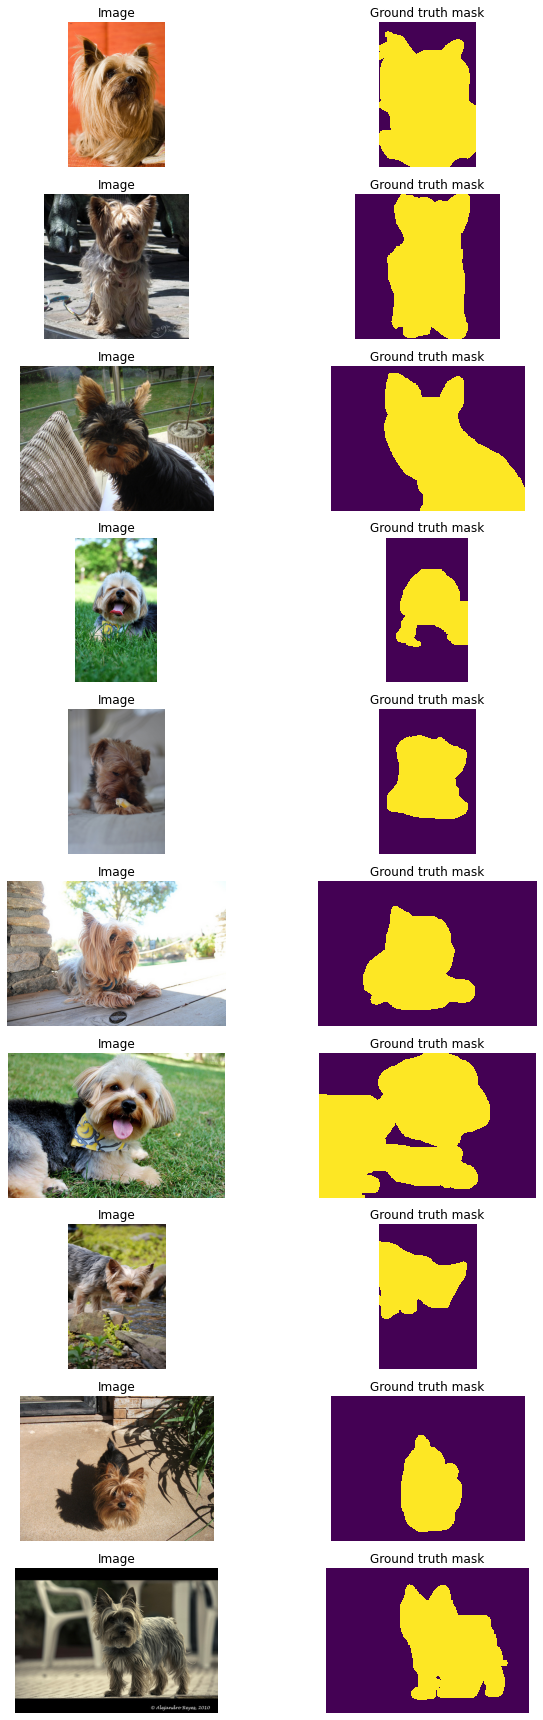

In [12]:
display_image_grid(test_images_filenames, images_directory, masks_directory)

### Image sizes for training and prediction
----

Often, images that you use for training and inference have different heights and widths and different aspect ratios. That fact brings two challenges to a deep learning pipeline:
- PyTorch requires all images in a batch to have the same height and width;
- If a neural network is not fully convolutional, you have to use the same width and height for all images during training and inference. Fully convolutional architectures, such as U-Net, can work with images of any size.

<br>

There are three common ways to deal with those challenges:
1. Resize all images and masks to a fixed size (e.g., 256x256 pixels) during training. After a model predicts a mask with that fixed size during inference, resize the mask to the original image size. This approach is simple, but it has a few drawbacks:
  - The predicted mask is smaller than the image, and the mask may lose some context and important details of the original image; 
  - This approach may be problematic if images in your dataset have different aspect ratios. For example, suppose you are resizing an image with the size 1024x512 pixels (so an image with an aspect ratio of 2:1) to 256x256 pixels (1:1 aspect ratio). In that case, this transformation will distort the image and may also affect the quality of predictions;
2. If you use a fully convolutional neural network, you can train a model with image crops, but use original images for inference. This option usually provides the best tradeoff between quality, speed of training, and hardware requirements;
3. Do not alter the sizes of images and use source images both for training and inference. With this approach, you won't lose any information. However, original images could be quite large, so they may require a lot of GPU memory. Also, this approach requires more training time to obtain good results.

Some architectures, such as U-Net, require that an image's size must be divisible by a downsampling factor of a network (usually 32), so you may also need to pad an image with borders. Albumentations provides a particular transformation for that case.

The following example shows how different types of images look.

<br>

**PS**: In this modified tutorial, we will consider only the first two approaches. Moreover, the commented lines below show the original lines of code which have issues, and just below them the fixes we have done.

In [13]:
example_image_filename = correct_images_filenames[0]
image = cv2.imread(os.path.join(images_directory, example_image_filename))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#resized_image = F.resize(image, height=256, width=256)
dim = (256, 256)
resized_image = cv2.resize(image, dim)

padded_image = F.pad(image, min_height=512, min_width=512)
padded_constant_image = F.pad(image, min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT)
#cropped_image = F.center_crop(image, crop_height=256, crop_width=256)
cropped_image = C.center_crop(image, 256, 256)

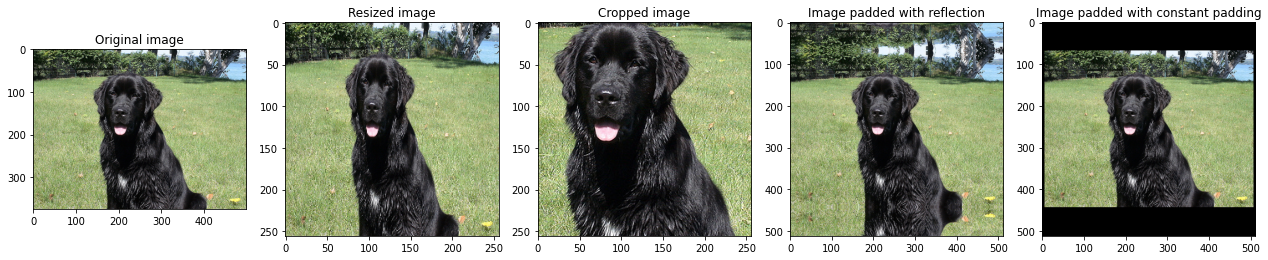

In [14]:
figure, ax = plt.subplots(nrows=1, ncols=5, figsize=(18, 10))
ax.ravel()[0].imshow(image)
ax.ravel()[0].set_title("Original image")
ax.ravel()[1].imshow(resized_image)
ax.ravel()[1].set_title("Resized image")
ax.ravel()[2].imshow(cropped_image)
ax.ravel()[2].set_title("Cropped image")
ax.ravel()[3].imshow(padded_image)
ax.ravel()[3].set_title("Image padded with reflection")
ax.ravel()[4].imshow(padded_constant_image)
ax.ravel()[4].set_title("Image padded with constant padding")
plt.tight_layout()
plt.show()


### Approach 1. Resize all images and masks to a fixed size (e.g., 256x256 pixels).

### Define a PyTorch dataset class

Next, we define a PyTorch dataset. If you are new to PyTorch datasets, please refer to this tutorial - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.

`__init__` will receive an optional `transform` argument. It is a transformation function of the Albumentations augmentation pipeline. Then in `__getitem__`, the Dataset class will use that function to augment an image and a mask and return their augmented versions.

In [15]:
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )
        mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

Next, we create augmentation pipelines for the training and validation datasets. Note that we use `A.Resize(256, 256)` to resize input images and masks to the size 256x256 pixels.

In [16]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = OxfordPetDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

Let's define a function that takes a dataset and visualises different augmentations applied to the same image and the associated mask.

In [17]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

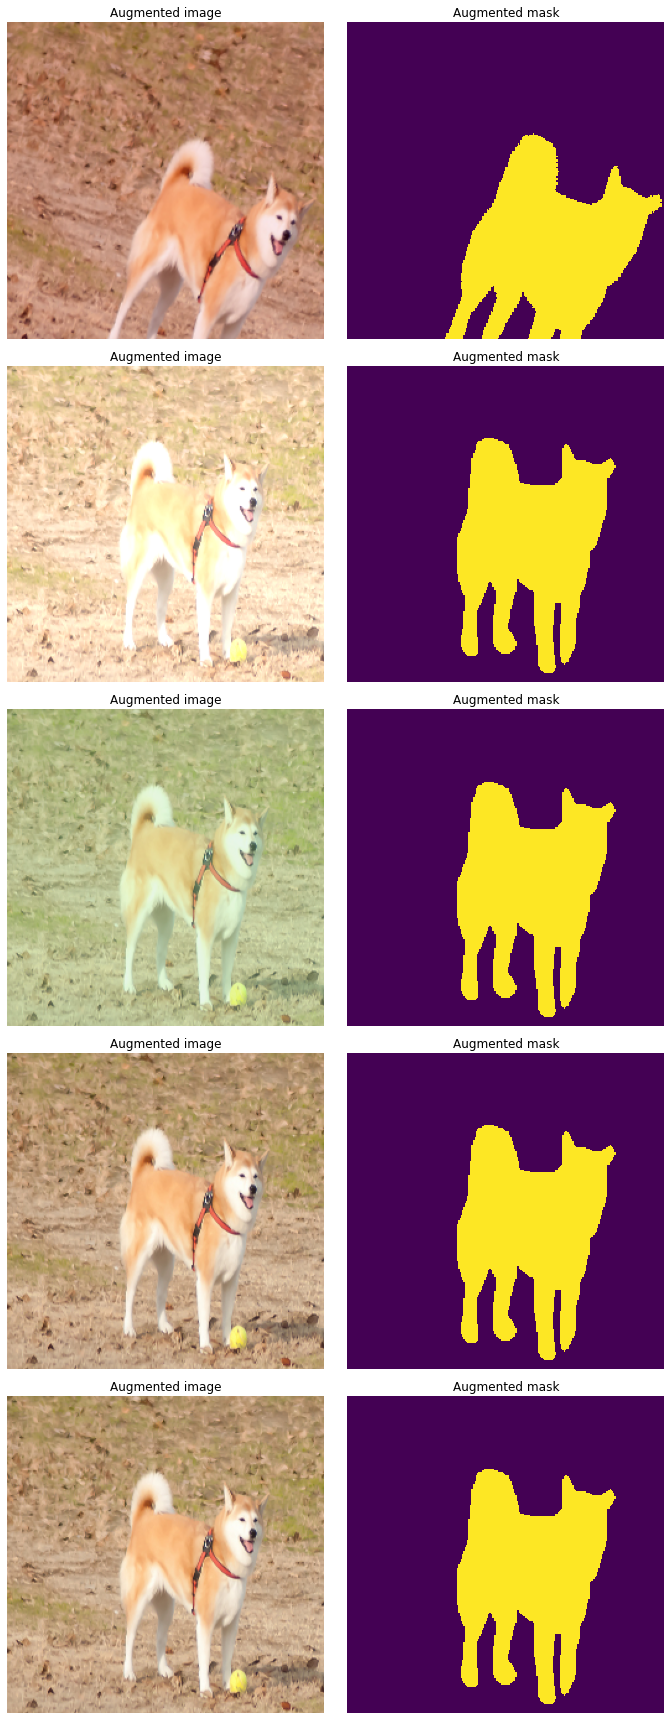

In [18]:
random.seed(42)
visualize_augmentations(train_dataset, idx=55)

### Define helpers for training

`MetricMonitor` helps to track metrics such as accuracy or loss during training and validation.

In [19]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

### Define functions for training and validation

In [20]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images).squeeze(1)
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [21]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images).squeeze(1)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [22]:
def create_model(params):
    model = getattr(ternausnet.models, params["model"])(pretrained=True)
    model = model.to(params["device"])
    return model

In [23]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    criterion = nn.BCEWithLogitsLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        validate(val_loader, model, criterion, epoch, params)
    return model

In [24]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

### Define training parameters 

Here we define a few training parameters such as model architecture, learning rate, batch size, epochs, etc.

In [25]:
params = {
    "model": "UNet11",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 4,
    "epochs": 10,
}

### U-Net11
----

TernausNet uses as encoder the VGG11 (UNet11) or VGG16 (UNet16). We selected UNet11 as our encoder in this tutorial.

<br>

<img src="https://drive.google.com/uc?id=1CeQ87_50ZSHl_QuxDabuoM3VSpY4P7Sb" alt="Drawing" width="350"/>

<br>

Below, we show how this is done. Note the index of the VGG11 layers to understand the architecture of the encoder.

### Check and train a model
----

In [26]:
model = create_model(params)

# Just checking the number of trainable parameters
print('Checking trainable parameters: {}'.format(count_parameters(model)))

+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|      encoder.0.weight      |    1728    |
|       encoder.0.bias       |     64     |
|      encoder.3.weight      |   73728    |
|       encoder.3.bias       |    128     |
|      encoder.6.weight      |   294912   |
|       encoder.6.bias       |    256     |
|      encoder.8.weight      |   589824   |
|       encoder.8.bias       |    256     |
|     encoder.11.weight      |  1179648   |
|      encoder.11.bias       |    512     |
|     encoder.13.weight      |  2359296   |
|      encoder.13.bias       |    512     |
|     encoder.16.weight      |  2359296   |
|      encoder.16.bias       |    512     |
|     encoder.18.weight      |  2359296   |
|      encoder.18.bias       |    512     |
| center.block.0.conv.weight |  2359296   |
|  center.block.0.conv.bias  |    512     |
|   center.block.1.weight    |  1179648   |
|    center.block.1.bias     |  

In [27]:
# Just checking the model
print(model)

model = train_and_validate(model, train_dataset, val_dataset, params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


UNet11(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)

  0%|          | 0/375 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch: 10. Validation. Loss: 0.148: 100%|██████████| 86/86 [00:25<00:00,  3.39it/s]


### Predict labels for images and visualise those predictions
----

Now we have a trained model, so let's try to predict masks for some images. Note that the `__getitem__` method returns not only an image but also the original height and width of an image. We will use those values to resize a predicted mask from the size of 256x256 pixels to the original image's size.

In [28]:
class OxfordPetInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

In [29]:
test_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
test_dataset = OxfordPetInferenceDataset(test_images_filenames, images_directory, transform=test_transform,)

In [30]:
predictions = predict(model, params, test_dataset, batch_size=16)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Next, we will resize the predicted masks with the size of 256x256 pixels to the original images' size.

<br>

**PS**: The commented lines below show the original lines of code which have issues, and just below them the fixes we have done.

In [31]:
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    #full_sized_mask = F.resize(
     #   predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
   #)
  dim = (original_width, original_height)  
  full_sized_mask = cv2.resize(
        predicted_256x256_mask, dim, interpolation=cv2.INTER_NEAREST
   )  
  predicted_masks.append(full_sized_mask)

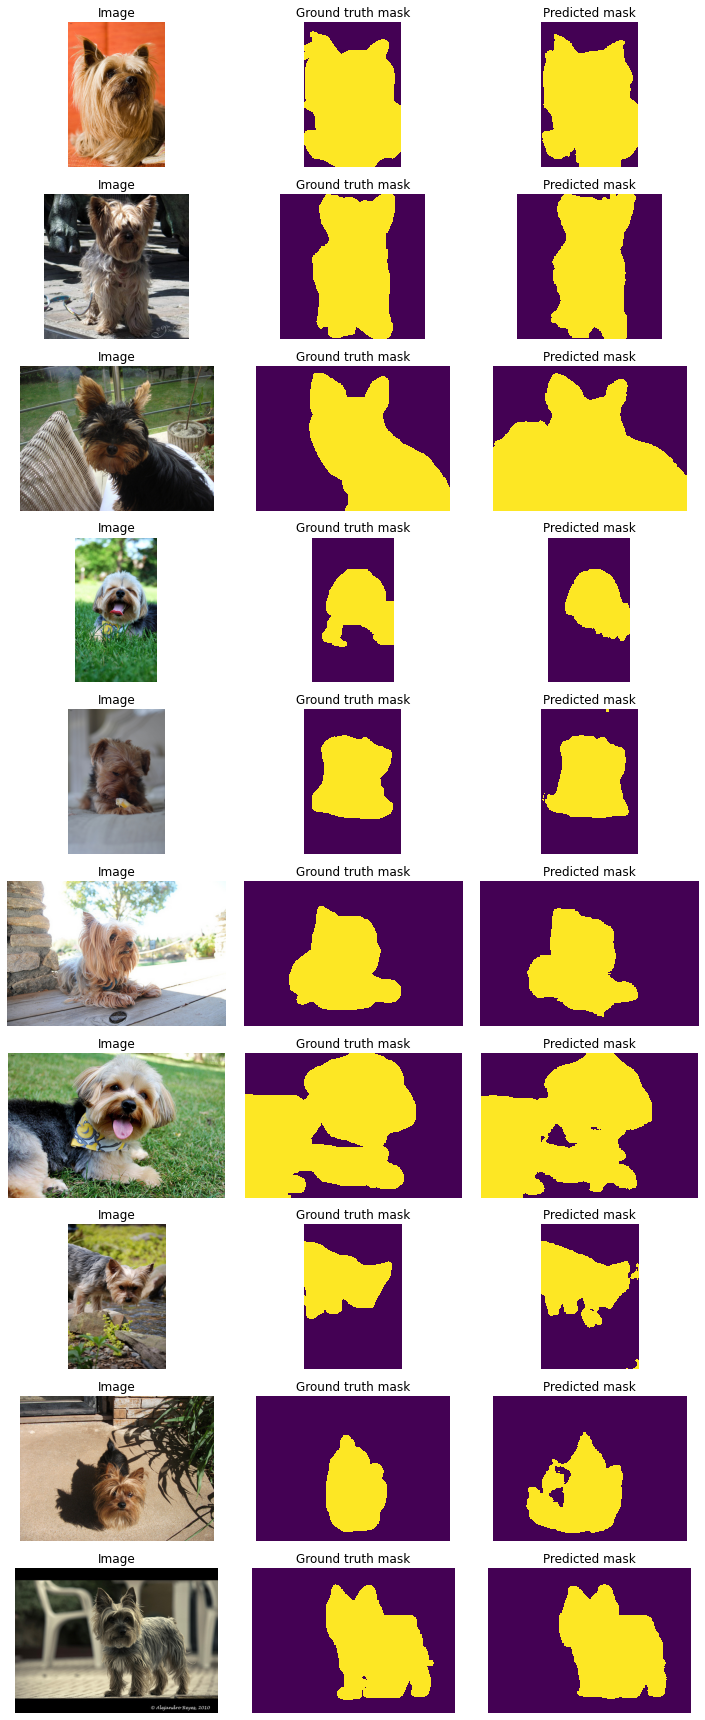

In [32]:
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)

### Approach 2: Train on crops, predict masks for full-sized images
----

We will reuse most of the code from the previous example.

Heights and widths of the same images in the dataset are less than the crop size (256x256 pixels), so we first apply `A.PadIfNeeded(min_height=256, min_width=256)` which will pad an image if its height or width is less than 256 pixels.

In [33]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.RandomCrop(256, 256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

In [34]:
val_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.CenterCrop(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = OxfordPetDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

In [35]:
params = {
    "model": "UNet11",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 4,
    "epochs": 10,
}

In [36]:
model = create_model(params)

model = train_and_validate(model, train_dataset, val_dataset, params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch: 10. Validation. Loss: 0.158: 100%|██████████| 86/86 [00:25<00:00,  3.36it/s]


All images in the test dataset have a max side with size 500 pixels. Since PyTorch requires that all images in a batch must have the same dimensions, and also U-Net requires that the size of an image will be divisible by 16, we will apply `A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT)`. That augmentation will pad image borders with zeros so the image size will become 512x512 pixels.

In [37]:
test_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = OxfordPetInferenceDataset(test_images_filenames, images_directory, transform=test_transform,)

In [38]:
predictions = predict(model, params, test_dataset, batch_size=16)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Since we received masks for padded images, we need to crop part of the original image size from the padded mask.

<br>

**PS**: The commented line below shows the original line of code which has issue, and just below them the fix we have done.


In [39]:
predicted_masks = []
for predicted_padded_mask, original_height, original_width in predictions:
    #cropped_mask = F.center_crop(predicted_padded_mask, original_height, original_width)
    cropped_mask = C.center_crop(predicted_padded_mask, original_height, original_width)
    predicted_masks.append(cropped_mask)

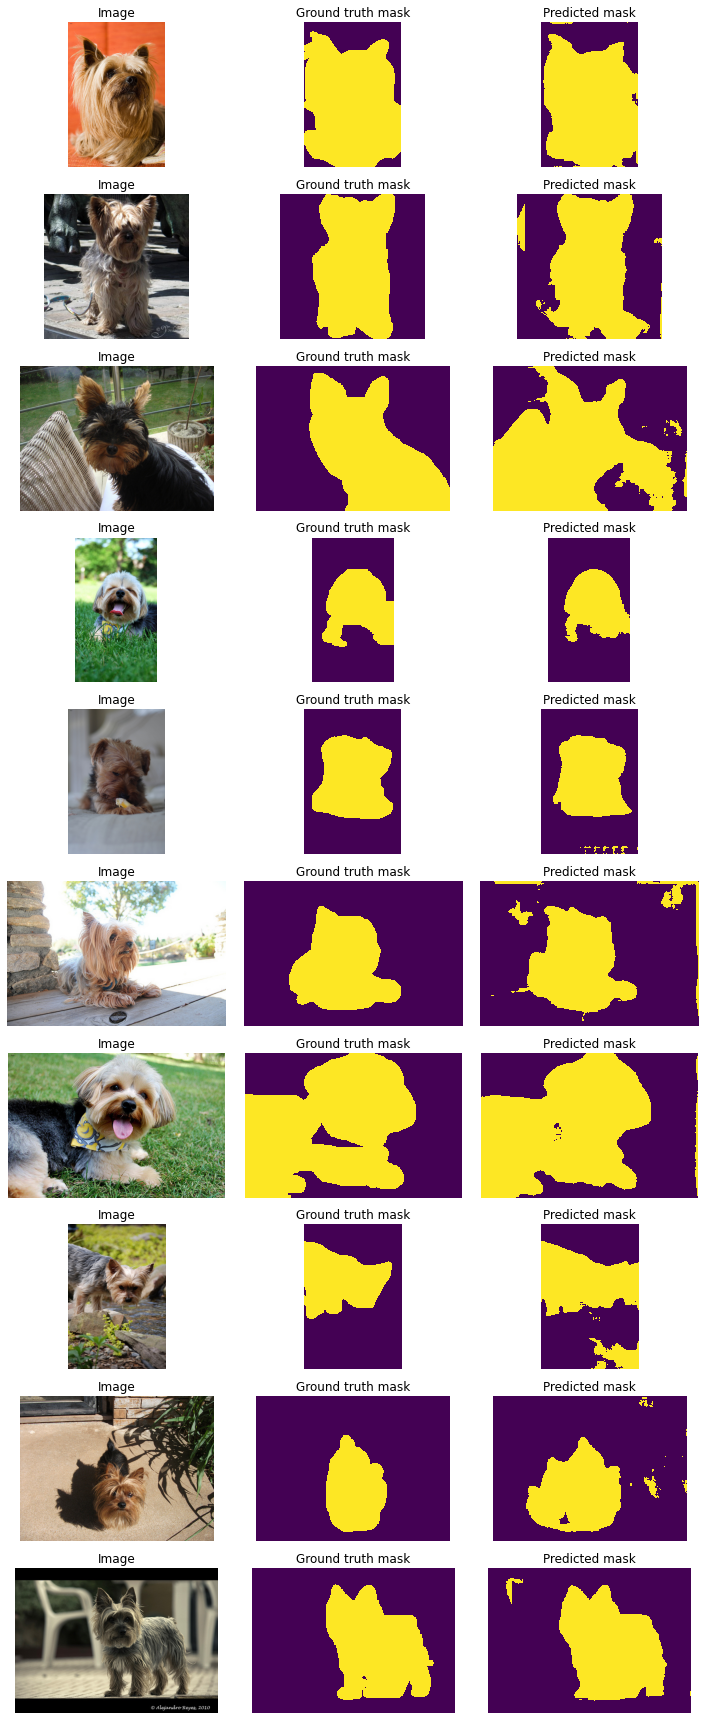

In [40]:
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)